In [1]:
"""
# Define pitch
F = [0,1,0] ; E_sharp = [0,1,0]
C = [1,0,1] ; B_sharp = [1,0,1] 
G = [0,-1,2]
D = [-1,0,3]
A = [0,1,4]
E = [1,0,5]  ; F_flat = [1,0,5]
B = [0,-1,6]  ; C_flat = [0,-1,6]
F_sharp = [-1,0,7] ; G_flat = [-1,0,7]
C_sharp = [0,1,8] ; D_flat = [0,1,8]
G_sharp = [1,0,9] ; A_flat = [1,0,9]
D_sharp = [0,-1,10] ; E_flat = [0,-1,10]
A_sharp = [-1,0,11] ; B_flat = [-1,0,11]
"""
print()

In [2]:
import librosa
import os, sys
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from librosa import display
warnings.filterwarnings('ignore')

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
pitch_ary = np.array(pitch_ary)

## get all clip 
def get_dirs(path):
    dirs = os.listdir(path)
    return dirs  # file list

def pitch_trans(seq):
    pitch_list = ['C','C#','D','D#(E-)','E','F','F#','G','G#','A','A#(B-)','B']
    return pitch_list[seq]

def pitch_to_ary(notes):
    pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
    pitch_ary = np.array(pitch_ary)
    return pitch_ary[notes]


## count CE
def count_CE(notes_seq):
    c = Counter(notes_seq)
    Dab = 0
    sum_dp = 0
    for i in range(len(notes_seq)):
        pij = (pitch_to_ary(notes_seq[i]))
        dij = 1
        Dab = sum(c.values())
        sum_dp += (dij * pij)  
        CE = sum_dp/Dab   
    return CE

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

In [4]:
## Analysis chord and pitch
def n_gram(key_list, ngram):
    k_list = [[word for word in line.split(",")] for line in key_list]
    flattened = [val for sublist in k_list for val in sublist]
    ngram_key = []
    for i in range(int(len(flattened)/ngram)):
        ngram_key.append(flattened[ngram*i : ngram*(i+1)])
    count_ary = [[x,ngram_key.count(x)] for x in (ngram_key)]
    unique = []
    for item in count_ary:
        if item not in unique:
            unique.append(item)
    unique = sorted(unique, key=lambda x:x[1], reverse = True)
    return unique

## key matching
perfect_five = [['C','G'],['G','D'],['D','A'],['A','E'],['E','B'],['B','F#'],['F#','C#'],['C#','G#'],
                ['G#','D#(E-)'],['D#(E-)','A#(B-)'],['A#(B-)','F'],['F','C']]
same_pitch = [['C','C','C'],['D','D','D'],['A','A','A'],['E','E','E'],['B','B','B'],['F#','F#','F#'],
              ['C#','C#','C#'],['G#','G#','G#'], ['D#(E-)','D#(E-)','D#(E-)'],
              ['A#(B-)','A#(B-)','A#(B-)'],['F','F','F'],['G','G','G']]
big_three = [['C','E'],['D','F#'],['E','G#'],['F','A'],['G','B'],['A','C#'],['B','D#'],
             ['C#','F'],['D#(E-)','G'],['F#','A#(B-)'],['G#','C'],['A#','D']]
small_three = [['C','D#'],['D','F'],['E','G'],['F','G#'],['G','A#'],['A','C'],['B','D'],
             ['C#','E'],['D#(E-)','F#'],['F#','A'],['G#','B'],['A#','C#']]

In [5]:
## get all file name
sleeping_music = sorted(get_dirs('./music/sleeping'))

### Get Chord (4 beats)

In [6]:
sleeping_key = []; pitch = []
def job(num1, num2):
#     for idx in range(len(sleeping_music)):
    for idx in range(num1, num2):
        temp2 = []; temp3 = []
        for i in range(60):
            try:
                y1, sr = librosa.load('./music/sleeping/'+ sleeping_music[idx],offset=4*i,duration = 4, res_type = "kaiser_fast")
                ## onset detection
                o_env = librosa.onset.onset_strength(y1, sr=sr)
                onset_frames = librosa.onset.onset_detect(y=y1, onset_envelope=o_env, sr=sr)

                ## pitch detection
                b = librosa.feature.chroma_stft(y=y1, sr=sr, n_fft=1024, hop_length=512)

                temp =[]
                for i in range(len(onset_frames)): 
                    temp.append(np.argsort(b[:,onset_frames[i]])[-1])  
                for i in range(len(temp)):
                    temp3.append(pitch_trans(temp[i]))    

                ## count CE
                CE = (count_CE(temp))
                temp2.append(get_key(CE, pitch_ary))
            except:
                pass
        sleeping_key.append(temp2)
        pitch.append(temp3)
        print("Finish", idx)

In [7]:
import threading
import time

## multi thread

threads = []
threads2 = []
threads3 = []
threads4 = []

threads.append(threading.Thread(target = job, args = (0,12))) 
for t in threads:
    t.start()
    
threads2.append(threading.Thread(target = job, args = (12,24))) 
for t2 in threads2:
    t2.start()
    
threads3.append(threading.Thread(target = job, args = (24,38))) 
for t2 in threads3:
    t2.start()
    
threads4.append(threading.Thread(target = job, args = (38,51))) 
for t2 in threads4:
    t2.start()

In [10]:
len(sleeping_key)

4

Finish 13
Finish 25
Finish 1
Finish 39
Finish 14
Finish 26
Finish 2
Finish 40
Finish 15
Finish 27
Finish 3
Finish 41
Finish 16
Finish 28
Finish 4
Finish 42
Finish 17
Finish 29
Finish 5
Finish 43
Finish 18
Finish 30
Finish 6
Finish 44


## Analysis - Chord

In [9]:
## Chord progression
for idx in range(len(sleeping_music)):
    perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0
    perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0
    for i in range(len(sleeping_key[idx])):
        if sleeping_key[idx][i:i+2] in perfect_five:
            perfect = perfect+1
        elif sleeping_key[idx][i:i+2] in big_three:
            big3 = big3+1
        elif sleeping_key[idx][i:i+2] in small_three:
            small3 = small3+1
        else:
            non = non+1
    for i in range(len(sleeping_key[idx])):
        if sleeping_key[idx][i:i+3] in same_pitch:
            same = same+1
    try:
        perfect_ = round(perfect/len(sleeping_key[idx]) *100,2)
        same_ = round(same/len(sleeping_key[idx]) *100,2)
        non_ = round(non/len(sleeping_key[idx]) *100,2)
        big3_ = round(big3/len(sleeping_key[idx]) *100,2)
        small3_ = round(small3/len(sleeping_key[idx]) *100,2)
    except:
        pass
    print(idx,sleeping_music[idx])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Other",non_, '%')
    print()

IndexError: list index out of range

In [ ]:
print(sleeping_key[2])

Finish 12
Finish 0
Finish 24
Finish 38


## Analysis - Pitch

In [89]:
## Check if it has a dominant key
for idx in range(len(sleeping_music)):
    print(idx, n_gram(pitch[idx], 1))
    print()

0 [[['A'], 1943], [['E'], 671], [['G#'], 419], [['C#'], 306], [['F#'], 295], [['B'], 286], [['D#(E-)'], 6], [['A#(B-)'], 1], [['C'], 1]]

1 [[['C'], 1447], [['E'], 1287], [['G'], 1239], [['D'], 833], [['F'], 755], [['A'], 576], [['B'], 258], [['D#(E-)'], 63], [['C#'], 59], [['A#(B-)'], 43], [['G#'], 33], [['F#'], 29]]

2 [[['C'], 838], [['G'], 752], [['A'], 734], [['F'], 625], [['D'], 577], [['E'], 440], [['D#(E-)'], 16], [['C#'], 4], [['G#'], 1], [['A#(B-)'], 1], [['B'], 1], [['F#'], 1]]

3 [[['C'], 988], [['G'], 589], [['F'], 547], [['A'], 425], [['E'], 406], [['D'], 337], [['B'], 260], [['F#'], 40], [['G#'], 16], [['D#(E-)'], 11], [['C#'], 8]]

4 [[['A'], 664], [['F#'], 507], [['B'], 474], [['E'], 409], [['C#'], 301], [['D'], 276], [['G'], 256], [['G#'], 138], [['D#(E-)'], 72], [['A#(B-)'], 68], [['C'], 64], [['F'], 44]]

5 [[['A'], 428], [['E'], 262], [['G'], 248], [['D'], 246], [['B'], 218], [['F#'], 216], [['C'], 120], [['C#'], 78], [['D#(E-)'], 49], [['F'], 35], [['G#'], 20], [[

48 [[['D'], 2888], [['C'], 2218], [['D#(E-)'], 1758], [['C#'], 655], [['A'], 89], [['E'], 80], [['F'], 78], [['B'], 47], [['G#'], 36], [['F#'], 4], [['A#(B-)'], 3], [['G'], 2]]

49 [[['G#'], 604], [['C'], 509], [['F'], 485], [['E'], 452], [['G'], 448], [['A#(B-)'], 417], [['A'], 382], [['F#'], 357], [['B'], 341], [['D#(E-)'], 326], [['C#'], 303], [['D'], 161]]

50 [[['F'], 337], [['C'], 291], [['D'], 249], [['A#(B-)'], 217], [['A'], 204], [['G'], 203], [['E'], 94], [['B'], 68], [['D#(E-)'], 14], [['C#'], 11], [['G#'], 6], [['F#'], 1]]

51 [[['G'], 535], [['D'], 391], [['B'], 325], [['A'], 236], [['E'], 207], [['C'], 174], [['F#'], 150], [['F'], 61], [['G#'], 5], [['A#(B-)'], 3]]

52 [[['C'], 4400], [['G'], 1302], [['F'], 863], [['E'], 598], [['D'], 414], [['A'], 278], [['C#'], 201], [['B'], 95], [['D#(E-)'], 32], [['A#(B-)'], 21], [['F#'], 17], [['G#'], 3]]

53 [[['F'], 741], [['C'], 640], [['G'], 640], [['D'], 603], [['A#(B-)'], 593], [['D#(E-)'], 492], [['G#'], 449], [['C#'], 125], [

In [1]:
## Pitch progression
for idx in range(len(sleeping_music)):
    same = 0; same_ = 0
    for i in range(len(pitch[idx])):
        if pitch[idx][i:i+3] in same_pitch:
            same = same+1
    
    
    print(idx,sleeping_music[idx])
    print("Stable:",same/len(pitch[idx])*100)
    print()

NameError: name 'sleeping_music' is not defined

In [ ]:
# o_env = librosa.onset.onset_strength(y1, sr=sr)
# times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

# import matplotlib.pyplot as plt
# D = np.abs(librosa.stft(y1))
# plt.figure()
# ax1 = plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                           x_axis='time', y_axis='log')
# plt.title('Power spectrogram')
# plt.subplot(2, 1, 2, sharex=ax1)
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')
# plt.legend(frameon=True, fram1ealpha=0.75)

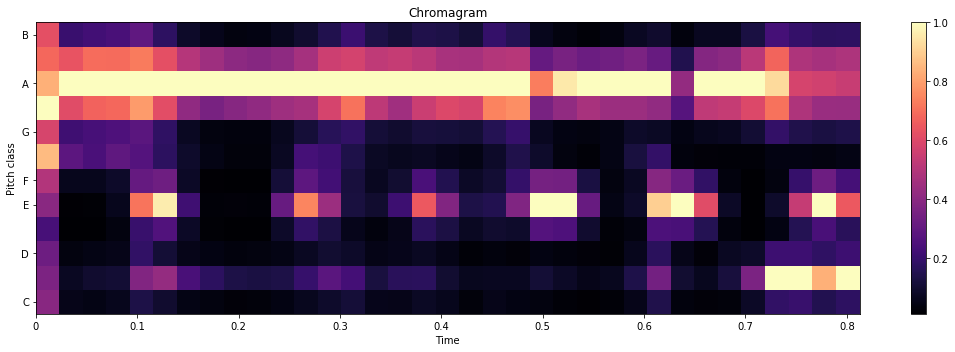

In [37]:
# for i in range(2):
# y,sr = librosa.load('./test/soda/'+ clip_list2[i])    
b = librosa.feature.chroma_stft(y=y1, sr=sr,  n_fft=1024, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(b, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [ ]:
# ## split audio
# def chunk_wav(file, chunk_ms,folder, title):
#     chunks = make_chunks(file, chunk_ms)
#     # Export all of the individual chunks as wav files
#     for i, chunk in enumerate(chunks):
#         chunk_name = os.path.join("./test", folder,"{0}_chunk{1}.wav".format(title, i))
#         librosa.output.write_wav(chunk_name, chunk, sr)
